In [1]:
import matplotlib.pyplot as plt
from time import time
from simfunctions import *

# Homodimerization

$$ \emptyset \xrightarrow{k_1} mX_1 $$
$$ X_1 + X_1 \xrightarrow{k_2} X_2 $$
$$ X_1 \xrightarrow{k_3} \emptyset, \quad X_2 \xrightarrow{k_3} \emptyset$$

with parameter $k_1 = 1000, k_2 = 100, k_3 = 10$.

In [2]:
def rate1(X):
    return 1

def rate2(X):
    rate = X[0]*(X[0]-1)  # 0.5(X^2 - X) 
    if rate > 0:
        return rate
    else:
        return 0

def rate3(X):
    rate = X[0]
    if rate > 0:
        return rate
    else:
        return 0
    
def rate4(X):
    rate = X[1]
    if rate > 0:
        return rate
    else:
        return 0
    
# Model Parameters
drift = [rate1, rate2, rate3, rate4]
S_matrix = np.array([[1, 0], [-2, 1], [-1, 0], [0, -1]])  # Stoichiometry matrix
c = np.array([5, 2.5, 0.5, 0.5])  # Reaction rates
X0 = np.array([20, 0])  # Initial state
T = 1  # Total time


## SSA

In [3]:
n_runs = 5000
runs = []

for run in range(n_runs):
    if 100*run/n_runs % 10 == 0:
        print(100*run/n_runs, '% simulations completed')
    X = None
    while X is None:
        X, t_ssa = next_reaction(drift, S_matrix, c, X0, T)
    runs.append(X)
    
x_ssa = np.mean(np.array(runs), axis=0)


0.0 % simulations completed


C:\Users\birik\github\SOGA4SSA\src\simfunctions.py:25: RuntimeWarning: divide by zero encountered in divide
  rand_vars = np.random.exponential(1 / a)


10.0 % simulations completed
20.0 % simulations completed
30.0 % simulations completed
40.0 % simulations completed
50.0 % simulations completed
60.0 % simulations completed
70.0 % simulations completed
80.0 % simulations completed
90.0 % simulations completed


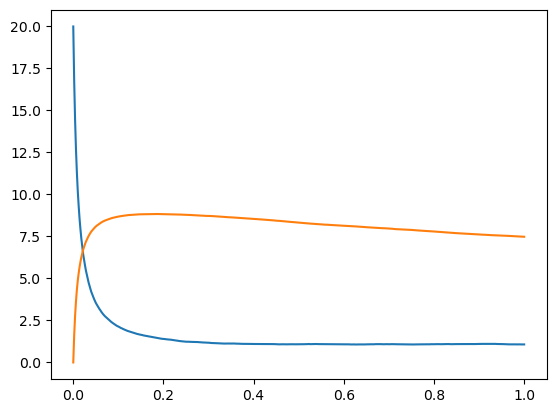

In [4]:
plt.plot(t_ssa, x_ssa)

## Tau-leaping

In [5]:
tau = 0.005  # Leap size

n_runs = 1000
runs = []

for run in range(n_runs):
    if 100*run/n_runs % 10 == 0:
        print(100*run/n_runs, '% simulations completed')
    X = None
    while X is None:
        X, t_tau = tau_leaping(drift, S_matrix, c, X0, T, tau)
    runs.append(X)
    
print('Number of steps: ', len(X))

0.0 % simulations completed
Negative population, restarting run
Negative population, restarting run
Negative population, restarting run
Negative population, restarting run
Negative population, restarting run
Negative population, restarting run
Negative population, restarting run
Negative population, restarting run
Negative population, restarting run
Negative population, restarting run
Negative population, restarting run
Negative population, restarting run
Negative population, restarting run
Negative population, restarting run
Negative population, restarting run
10.0 % simulations completed
Negative population, restarting run
Negative population, restarting run
Negative population, restarting run
Negative population, restarting run
Negative population, restarting run
Negative population, restarting run
Negative population, restarting run
Negative population, restarting run
Negative population, restarting run
Negative population, restarting run
20.0 % simulations completed
Negative popul

In [6]:
std_tau = np.std(runs, axis=0)[:,0]

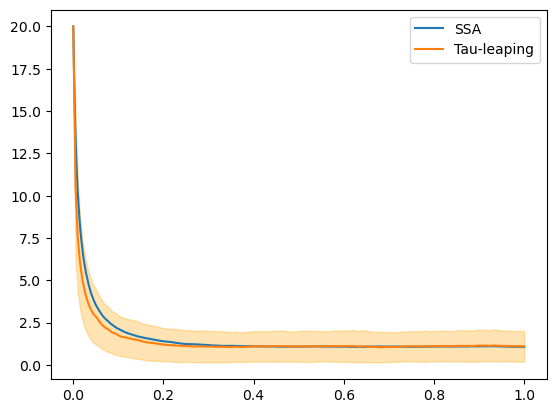

In [7]:
x_tau = np.mean(runs, axis=0)

plt.plot(t_ssa, x_ssa[:,0], label='SSA')
plt.plot(t_tau, x_tau[:,0], label='Tau-leaping')
plt.fill_between(t_tau, x_tau[:,0]-std_tau, x_tau[:,0]+std_tau ,alpha=0.3, color='orange')
plt.legend()

## Mean-field

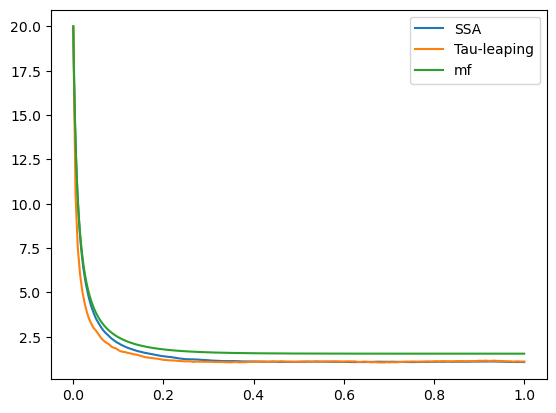

In [8]:

tmf = np.linspace(0,T, 5000)
Xmf = mean_field(drift,S_matrix,c,X0,tmf)

plt.plot(t_ssa, x_ssa[:,0], label='SSA')
plt.plot(t_tau, x_tau[:,0], label='Tau-leaping')
plt.plot(tmf, Xmf[:,0], label='mf')
plt.legend()


## SOGA 

In [10]:
from sogaPreprocessor import *
from producecfg import *
from libSOGA import *

compiledFile=compile2SOGA('../programs/SOGA/SSA/HomodimerizationX0=20.soga')
cfg = produce_cfg(compiledFile)
start = time()
output_dist = start_SOGA(cfg)
end = time()

print('Computed in {}s'.format(np.round(end-start,3)))

Computed in 50.494s


In [11]:
t = len(t_tau)

x1 = np.zeros(t)
x2 = np.zeros(t)
std1 = np.zeros(t)
std2 = np.zeros(t)

for i in range(t):
    idx1 = output_dist.var_list.index('X0[{}]'.format(i))
    idx2 = output_dist.var_list.index('X1[{}]'.format(i))
    x1[i] = output_dist.gm.mean()[idx1]
    std1[i] = np.sqrt(output_dist.gm.cov()[idx1,idx1])
    x2[i] = output_dist.gm.mean()[idx2]
    std2[i] = np.sqrt(output_dist.gm.cov()[idx2,idx2])

(-1.0, 5.0)

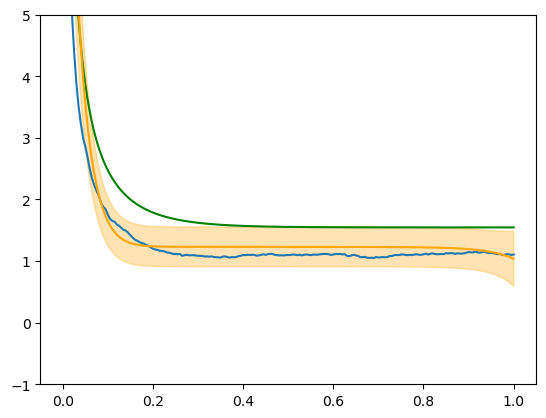

In [14]:
plt.plot(t_tau, x_tau[:,0], label='tau-leaping')
plt.plot(tmf, Xmf[:,0], label='mean-field', color='green')
plt.plot(t_tau, x1, label='SOGA', color='orange')
plt.fill_between(t_tau, x1-std1, x1+std1 ,alpha=0.3, color='orange')
plt.ylim(-1,5)

## Without observe

(-5.0, 5.0)

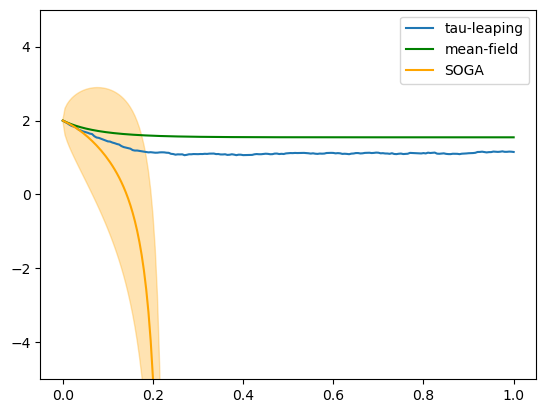

In [15]:
# correction term

plt.plot(t_tau, x_tau[:,0], label='tau-leaping')
plt.plot(tmf, Xmf[:,0], label='mean-field', color='green')
plt.plot(t_tau, x1, label='SOGA', color='orange')
plt.fill_between(t_tau, x1-std1, x1+std1 ,alpha=0.3, color='orange')
plt.legend()
plt.ylim(-5,5)

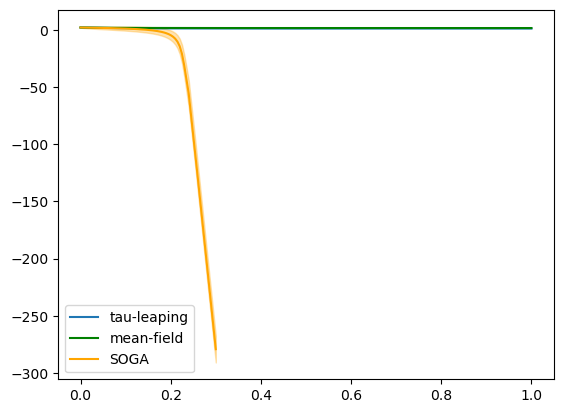

In [11]:
# half variance

plt.plot(t_tau, x_tau[:,0], label='tau-leaping')
plt.plot(tmf, Xmf[:,0], label='mean-field', color='green')
plt.plot(t_tau, x1, label='SOGA', color='orange')
plt.fill_between(t_tau, x1-std1, x1+std1 ,alpha=0.3, color='orange')
plt.legend()

(-5.0, 5.0)

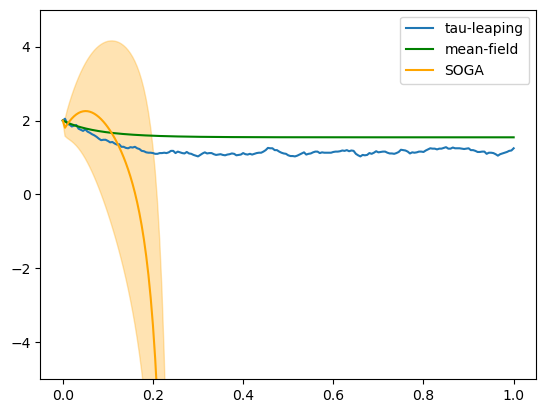

In [12]:
# correcting poisson(N)

plt.plot(t_tau, x_tau[:,0], label='tau-leaping')
plt.plot(tmf, Xmf[:,0], label='mean-field', color='green')
plt.plot(t_tau, x1, label='SOGA', color='orange')
plt.fill_between(t_tau, x1-std1, x1+std1 ,alpha=0.3, color='orange')
plt.legend()
plt.ylim(-5,5)

(-5.0, 5.0)

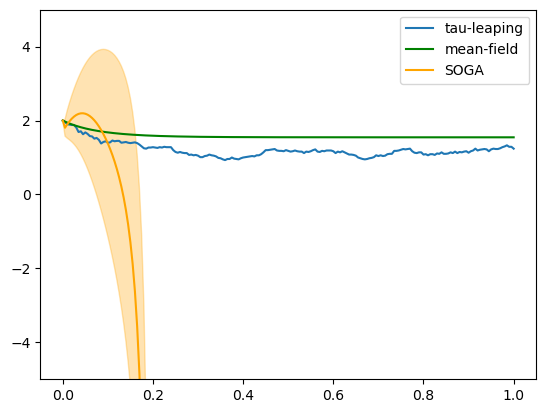

In [12]:
# correcting poisson(delta)

plt.plot(t_tau, x_tau[:,0], label='tau-leaping')
plt.plot(tmf, Xmf[:,0], label='mean-field', color='green')
plt.plot(t_tau, x1, label='SOGA', color='orange')
plt.fill_between(t_tau, x1-std1, x1+std1 ,alpha=0.3, color='orange')
plt.legend()
plt.ylim(-5,5)

(-5.0, 5.0)

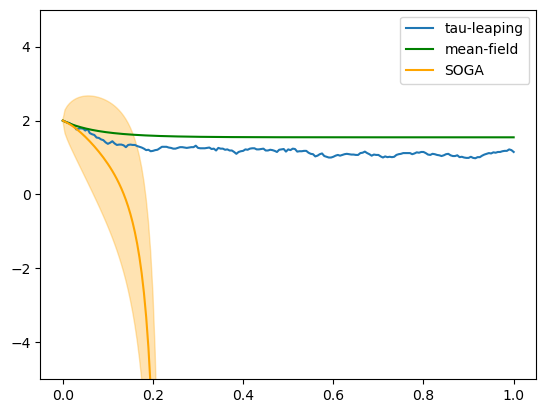

In [13]:
# correcting only k2

plt.plot(t_tau, x_tau[:,0], label='tau-leaping')
plt.plot(tmf, Xmf[:,0], label='mean-field', color='green')
plt.plot(t_tau, x1, label='SOGA', color='orange')
plt.fill_between(t_tau, x1-std1, x1+std1 ,alpha=0.3, color='orange')
plt.legend()
plt.ylim(-5,5)